# Titanic - Machine Learning from Disaster

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

Link to contest : https://www.kaggle.com/c/titanic/overview/description

## 1) Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import xgboost as xgb
import seaborn as sns
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2) Data Preprocessing

* **Data Dictionary**

- survival ---	Survival	0 = No, 1 = Yes
- pclass	 ---   Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
- sex	     ---   Sex	
- Age	     ---   Age in years	
- sibsp    ---  	# of siblings / spouses aboard the Titanic	
- parch    --- 	# of parents / children aboard the Titanic	
- ticket	 ---   Ticket number	
- fare	   ---   Passenger fare	
- cabin    --- 	Cabin number	
- embarked --- 	Port of Embarkation	C = Cherbourg, Q =  Queenstown, S = Southampton

- Variable Notes
* pclass: A proxy for socio-economic status (SES)<br>
1st = Upper<br>
2nd = Middle<br>
3rd = Lower<br>

* age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

* sibsp: The dataset defines family relations in this way...<br>
Sibling = brother, sister, stepbrother, stepsister<br>
Spouse = husband, wife (mistresses and fiancés were ignored)

* parch: The dataset defines family relations in this way...<br>
Parent = mother, father<br>
Child = daughter, son, stepdaughter, stepson<br>
Some children travelled only with a nanny, therefore parch=0 for them.

In [2]:
# For train

df_train = pd.read_csv('drive/My Drive/Pytorch_DataSet/Titanic Data/train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# For test 

df_test = pd.read_csv('drive/My Drive/Pytorch_DataSet/Titanic Data/test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [0]:
def title_corr(t):
    newt = t
    if t == 'Mrs' or t == 'Mr' or t == 'Miss':
        return newt
    elif t == 'Capt' or t == 'Col' or t == 'Major' or t == 'Dr' or t == 'Rev':
        newt = 'Crew'
    elif t == 'Jonkheer' or t == 'Sir' or t == 'the Countess' or t == 'Lady' or t == 'Master':
        newt = 'Noble'
    elif t == 'Don':
        newt = 'Mr'
    elif t == 'Dona' or t == 'Ms' or t == 'Mme':
        newt = 'Mrs'
    elif t == 'Mlle':
        newt = 'Miss'
    else: print("Title not included:", t)
    return newt

# Extract the titles from the name and put them in a list, then correct them

# Train data

train_titles = list()
for name in df_train["Name"]:
    train_titles.append(name.split(',')[1].split('.')[0].strip())
for i in range(len(train_titles)):
    train_titles[i] = title_corr(train_titles[i])
df_train["Titles"] = train_titles

# Test set 

test_titles = list()
for name in df_test["Name"]:
    test_titles.append(name.split(',')[1].split('.')[0].strip())
for i in range(len(test_titles)):
    test_titles[i] = title_corr(test_titles[i])
df_test["Titles"] = test_titles

In [0]:
# Train Data

df_train['Total Family'] = df_train['SibSp'] + df_train['Parch']

# Test Data

df_test['Total Family'] = df_test['SibSp'] + df_test['Parch']


In [6]:
# For train 

print(df_train.describe())

# For test 

print(df_test.describe())

       PassengerId    Survived  ...        Fare  Total Family
count   891.000000  891.000000  ...  891.000000    891.000000
mean    446.000000    0.383838  ...   32.204208      0.904602
std     257.353842    0.486592  ...   49.693429      1.613459
min       1.000000    0.000000  ...    0.000000      0.000000
25%     223.500000    0.000000  ...    7.910400      0.000000
50%     446.000000    0.000000  ...   14.454200      0.000000
75%     668.500000    1.000000  ...   31.000000      1.000000
max     891.000000    1.000000  ...  512.329200     10.000000

[8 rows x 8 columns]
       PassengerId      Pclass  ...        Fare  Total Family
count   418.000000  418.000000  ...  417.000000    418.000000
mean   1100.500000    2.265550  ...   35.627188      0.839713
std     120.810458    0.841838  ...   55.907576      1.519072
min     892.000000    1.000000  ...    0.000000      0.000000
25%     996.250000    1.000000  ...    7.895800      0.000000
50%    1100.500000    3.000000  ...   14.454200 

In [7]:
len(df_train) , len(df_test)

(891, 418)

In [8]:
# For train

df_train.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             177
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          2
Titles            0
Total Family      0
dtype: int64

In [9]:
# For test

df_test.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age              86
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin           327
Embarked          0
Titles            0
Total Family      0
dtype: int64

(array([ 54.,  46., 177., 169., 118.,  70.,  45.,  24.,   9.,   2.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <a list of 10 Patch objects>)

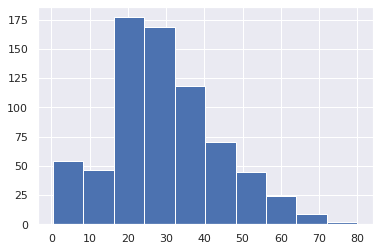

In [10]:
plt.hist(df_train['Age'])

(array([608., 209.,  28.,  16.,   0.,  18.,   5.,   0.,   0.,   7.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

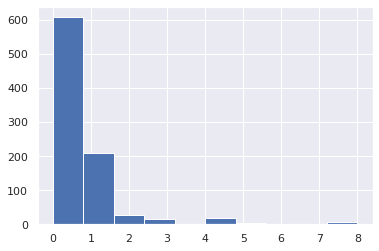

In [11]:
plt.hist(df_train['SibSp'])

(array([678., 118.,   0.,  80.,   0.,   5.,   4.,   0.,   5.,   1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

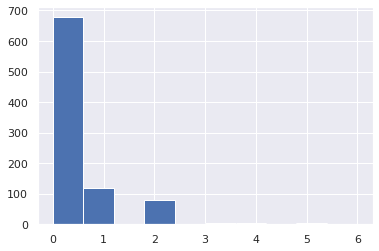

In [12]:
plt.hist(df_train['Parch'])

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   891 non-null    int64  
 1   Survived      891 non-null    int64  
 2   Pclass        891 non-null    int64  
 3   Name          891 non-null    object 
 4   Sex           891 non-null    object 
 5   Age           714 non-null    float64
 6   SibSp         891 non-null    int64  
 7   Parch         891 non-null    int64  
 8   Ticket        891 non-null    object 
 9   Fare          891 non-null    float64
 10  Cabin         204 non-null    object 
 11  Embarked      889 non-null    object 
 12  Titles        891 non-null    object 
 13  Total Family  891 non-null    int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 97.6+ KB


- Here, we can see that Cabin has got about 80-85% null values.So, it can be removed.
- Moreover, Name and Ticket are not good parameters for training.
- Therefore, these columns can be removed.

In [0]:
# For train

df_train['Cabin'] = df_train['Cabin'].fillna('Unknow')
df_train['Cabin2'] = df_train['Cabin'].apply(lambda x : len(x))

# For test

df_test['Cabin'] = df_test['Cabin'].fillna('Unknow')
df_test['Cabin2'] = df_test['Cabin'].apply(lambda x : len(x))

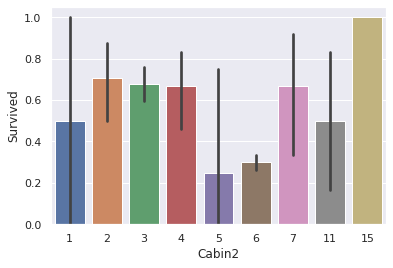

In [15]:
sns.barplot('Cabin2','Survived',data=df_train)

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   891 non-null    int64  
 1   Survived      891 non-null    int64  
 2   Pclass        891 non-null    int64  
 3   Name          891 non-null    object 
 4   Sex           891 non-null    object 
 5   Age           714 non-null    float64
 6   SibSp         891 non-null    int64  
 7   Parch         891 non-null    int64  
 8   Ticket        891 non-null    object 
 9   Fare          891 non-null    float64
 10  Cabin         891 non-null    object 
 11  Embarked      889 non-null    object 
 12  Titles        891 non-null    object 
 13  Total Family  891 non-null    int64  
 14  Cabin2        891 non-null    int64  
dtypes: float64(2), int64(7), object(6)
memory usage: 104.5+ KB


In [17]:
df_train.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             177
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin             0
Embarked          2
Titles            0
Total Family      0
Cabin2            0
dtype: int64

In [18]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin            0
Embarked         0
Titles           0
Total Family     0
Cabin2           0
dtype: int64

In [0]:
# For train 

df_train = df_train.drop('Name',axis=1)
df_train = df_train.drop('Ticket',axis=1)
df_train = df_train.drop('Cabin',axis=1)
df_train['Age'].fillna(df_train['Age'].median(),inplace=True)
df_train['Embarked'].fillna('S',inplace=True)

# For test

df_test['Fare'].fillna(df_test['Fare'].median(),inplace=True)
df_test = df_test.drop('Name',axis=1)
df_test = df_test.drop('Ticket',axis=1)
df_test = df_test.drop('Cabin',axis=1)
df_test['Age'].fillna(df_test['Age'].median(),inplace=True)

In [20]:
# Converting the Object datatype into Category type

cat_cols = []
for col in df_train.columns:
  if df_train[col].dtype == 'O':
    cat_cols.append(col)

print(cat_cols)    

['Sex', 'Embarked', 'Titles']


In [0]:
# For Train

for col in cat_cols:
  df_train[col] = df_train[col].astype('category')

# For Test

for col in cat_cols:
  df_test[col] = df_test[col].astype('category')


In [0]:
# Converting the category cols to integers

# For Train

for col in cat_cols:
  df_train[col] = df_train[col].cat.codes.values

# For Test

for col in cat_cols:
  df_test[col] = df_test[col].cat.codes.values  

In [23]:
# For train

train_cat_data = df_train[['Pclass','Sex','Embarked','Titles']].values
print(train_cat_data)

# For test
test_cat_data = df_test[['Pclass','Sex','Embarked','Titles']].values
print(test_cat_data)

[[3 1 2 2]
 [1 0 0 3]
 [3 0 2 1]
 ...
 [3 0 2 1]
 [1 1 0 2]
 [3 1 1 2]]
[[3 1 1 2]
 [3 0 2 3]
 [2 1 1 2]
 ...
 [3 1 2 2]
 [3 1 2 2]
 [3 1 0 4]]


In [24]:
# For train

print(max(df_train['Pclass']), max(df_train['Sex']), max(df_train['Embarked']),max(df_train['Titles']))
print(min(df_train['Pclass']), min(df_train['Sex']), min(df_train['Embarked']),min(df_train['Titles']))

3 1 2 4
1 0 0 0


In [25]:
# For test

print(max(df_test['Pclass']), max(df_test['Sex']), max(df_test['Embarked']),max(df_test['Titles']))
print(min(df_test['Pclass']), min(df_test['Sex']), min(df_test['Embarked']),min(df_test['Titles']))

3 1 2 4
1 0 0 0


In [26]:
from sklearn.preprocessing import OneHotEncoder 
  
onehotencoder = OneHotEncoder() 

# For train

train_cat_data = onehotencoder.fit_transform(train_cat_data).toarray()
print(train_cat_data.shape, type(train_cat_data))
print(train_cat_data)

# For test

test_cat_data = onehotencoder.transform(test_cat_data).toarray()
print(test_cat_data.shape, type(test_cat_data))
print(test_cat_data)


(891, 13) <class 'numpy.ndarray'>
[[0. 0. 1. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]]
(418, 13) <class 'numpy.ndarray'>
[[0. 0. 1. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 1.]]


In [27]:
df_train.isnull().sum()

PassengerId     0
Survived        0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
Titles          0
Total Family    0
Cabin2          0
dtype: int64

In [28]:
df_test.isnull().sum()

PassengerId     0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
Titles          0
Total Family    0
Cabin2          0
dtype: int64

In [0]:
# Splitting the data into features and labels

# For train

X = df_train[['Age','Fare','Total Family','Cabin2']].values
y = df_train['Survived'].values

# For test

X_test = df_test[['Age','Fare','Total Family','Cabin2']].values

In [30]:
X.shape, X[:10], type(X)

((891, 4), array([[22.    ,  7.25  ,  1.    ,  6.    ],
        [38.    , 71.2833,  1.    ,  3.    ],
        [26.    ,  7.925 ,  0.    ,  6.    ],
        [35.    , 53.1   ,  1.    ,  4.    ],
        [35.    ,  8.05  ,  0.    ,  6.    ],
        [28.    ,  8.4583,  0.    ,  6.    ],
        [54.    , 51.8625,  0.    ,  3.    ],
        [ 2.    , 21.075 ,  4.    ,  6.    ],
        [27.    , 11.1333,  2.    ,  6.    ],
        [14.    , 30.0708,  1.    ,  6.    ]]), numpy.ndarray)

In [31]:
# For train

X = np.concatenate((X,train_cat_data),axis=1)
print(X)

# For test 

X_test = np.concatenate((X_test,test_cat_data),axis=1)
print(X_test)

[[22.      7.25    1.     ...  1.      0.      0.    ]
 [38.     71.2833  1.     ...  0.      1.      0.    ]
 [26.      7.925   0.     ...  0.      0.      0.    ]
 ...
 [28.     23.45    3.     ...  0.      0.      0.    ]
 [26.     30.      0.     ...  1.      0.      0.    ]
 [32.      7.75    0.     ...  1.      0.      0.    ]]
[[34.5     7.8292  0.     ...  1.      0.      0.    ]
 [47.      7.      1.     ...  0.      1.      0.    ]
 [62.      9.6875  0.     ...  1.      0.      0.    ]
 ...
 [38.5     7.25    0.     ...  1.      0.      0.    ]
 [27.      8.05    0.     ...  1.      0.      0.    ]
 [27.     22.3583  2.     ...  0.      0.      1.    ]]


In [32]:
X.shape, type(X)

((891, 17), numpy.ndarray)

In [33]:
y.shape , y[:10]

((891,), array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1]))

In [34]:
X_test.shape, type(X_test)

((418, 17), numpy.ndarray)

In [35]:
input_data = xgb.DMatrix(data=X,label=y)
input_data

## 3) Splitting the data into train and test set

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1,random_state=0)

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

## 4) Building the XGBoost Model

In [0]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                          max_depth = 7,  
                          n_estimators = 100,
                          random_state = 10 )

In [39]:
xg_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## 6) Predicting the validation set results

In [0]:
y_preds = xg_clf.predict(X_val)

In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_preds,y_val)
print(cm)

[[46 12]
 [ 5 27]]


In [42]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_preds,y_val))

0.8111111111111111


In [0]:
# K-Fold Cross Validation

params = {"objective":"binary:logistic",
          'max_depth': 7, 
          'random_state': 10}

cv_results = xgb.cv(dtrain=input_data, 
                    params=params, 
                    nfold=5,
                    num_boost_round=100,
                    early_stopping_rounds=10, 
                    as_pandas=True, 
                    seed=123)

In [44]:
cv_results.head()

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.123177,0.005658,0.182964,0.015156
1,0.118125,0.006289,0.176235,0.016769
2,0.111392,0.004741,0.186341,0.022253
3,0.108025,0.003878,0.181853,0.024209
4,0.105498,0.003340,0.181853,0.018607


In [45]:
print((cv_results["test-error-mean"]).tail(1))

17    0.167265
Name: test-error-mean, dtype: float64


## 7) Predicting the actual results

In [0]:
y_pred = xg_clf.predict(X_test)

In [47]:
y_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

## 8) Saving the results into a csv file

In [48]:
submission = pd.DataFrame({'PassengerId':df_test['PassengerId'],'Survived':y_pred})
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [0]:
submission.to_csv('kaggle_titanic.csv',index=False)